# Training
Using the Naive Bayes classificator to predict if a word is an answer or not.

In [5]:
#Common imports 
import pandas as pd
import numpy as np

### Pickling

In [6]:
import _pickle as cPickle
from pathlib import Path

def dumpPickle(fileName, content):
    pickleFile = open(fileName, 'wb')
    cPickle.dump(content, pickleFile, -1)
    pickleFile.close()

def loadPickle(fileName):    
    file = open(fileName, 'rb')
    content = cPickle.load(file)
    file.close()
    
    return content
    
def pickleExists(fileName):
    file = Path(fileName)
    
    if file.is_file():
        return True
    
    return False

## Reading the dataframe
Generated from the *Feature Engineering* notebook

In [7]:
wordPickleName = '../data/pickles/wordsDf.pkl'
df = loadPickle(wordPickleName)

In [8]:
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,NER,POS,TAG,DEP,shape
0,Architecturally,False,0,0,0.0,1,None,ADV,RB,advmod,Xxxxx
1,school,False,0,0,0.0,1,None,NOUN,NN,nsubj,xxxx
2,Catholic,False,0,0,0.0,1,NORP,None,None,None,Xxxxx
3,character,False,0,0,0.0,1,None,NOUN,NN,dobj,xxxx
4,Atop,False,0,0,1.0,1,None,ADP,IN,prep,Xxxx


## One-hot encoding
We need to encode the categorical data - NER, POS, TAG, DEP, shape

In [9]:
columnsToEncode = ['NER', 'POS', "TAG", 'DEP']

In [10]:
for column in columnsToEncode:
    print(column)
    one_hot = pd.get_dummies(df[column])
    one_hot = one_hot.add_prefix(column + '_')

    df = df.drop(column, axis = 1)
    df = df.join(one_hot)

NER
POS
TAG
DEP


In [11]:
df.head()

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,shape,NER_CARDINAL,NER_DATE,NER_EVENT,...,DEP_nummod,DEP_oprd,DEP_parataxis,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_relcl,DEP_xcomp
0,Architecturally,False,0,0,0.0,1,Xxxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,school,False,0,0,0.0,1,xxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Catholic,False,0,0,0.0,1,Xxxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,character,False,0,0,0.0,1,xxxx,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Atop,False,0,0,1.0,1,Xxxx,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Remove columns
We need to remove the columns that are not features of the words.

In [12]:
columnsToDrop = ['text', 'titleId', 'paragrapghId', 'sentenceId', 'shape']

In [13]:
df = df.drop(columnsToDrop, axis = 1)

In [14]:
df.head()

,isAnswer,wordCount,NER_CARDINAL,NER_DATE,NER_EVENT,NER_FAC,NER_GPE,NER_LANGUAGE,NER_LAW,NER_LOC,...,DEP_nummod,DEP_oprd,DEP_parataxis,DEP_pcomp,DEP_pobj,DEP_poss,DEP_predet,DEP_prep,DEP_relcl,DEP_xcomp
0,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Split to test and train

In [15]:
from sklearn.model_selection import train_test_split

x_data = df.drop(labels=['isAnswer'], axis=1)
y_data = df['isAnswer']

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.1, 
                                                    random_state=4)

In [16]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

7810
7810
868
868


In [17]:
y_test.head()

5750    False
6978    False
4648    False
2742    False
3136    False
Name: isAnswer, dtype: bool

## Train model

In [18]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

In [19]:
predictor = gnb.fit(x_train, y_train)
y_pred = predictor.predict(x_test)

### Show Accuracy

In [20]:
correctCount = (y_test == y_pred).sum()

print('Correctly guessed:', '{:.2f}%'.format((correctCount / len(y_test)) * 100))

Correctly guessed: 28.46%


That doesn't really tell us anything. Since our dataset is not balanced - only 02,53%  of the words are answers we need to use a different metric.  

### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[209, 619],
       [  2,  38]], dtype=int64)

### Prettier confusion matrix

In [22]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
!pip install matplotlib

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


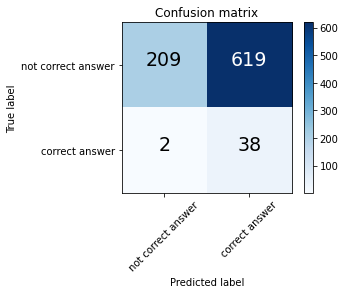

In [24]:
plot_confusion_matrix(y_test, y_pred, ['not correct answer', 'correct answer'], figsize=(5, 4))

In [25]:
y_test.value_counts()

False    828
True      40
Name: isAnswer, dtype: int64

In [26]:
y_pred_Series = pd.Series(y_pred)

In [27]:
y_pred_Series.value_counts()

True     657
False    211
dtype: int64

Seems like I'm super biased for towards correct answers. But as I found during the *Data exploration*, there are a lot more answer-worthy words that are just not labeled since, I guess the Mechanical Turks had the job to label just 5. So, who knows, maybe I did some black magic and managed to extract all the answer worthy words!

## Saving the model
We'll save our predictor, so we can use it to label new words.

In [28]:
predictorPickleName = '../data/pickles/nb-predictor.pkl'
dumpPickle(predictorPickleName, predictor)

#Because the one-hot encoding creates a different amount of features (columns in the dataframe), it is important to know which features are used in the Naive Bayes classifier as to not get into an error with different dimensions.
predictorFeaturesName = '../data/pickles/nb-predictor-features.pkl'
dumpPickle(predictorFeaturesName, list(df.columns))